In [ ]:
import os

!pip install kaggle

import kagglehub

# Download latest version
path = kagglehub.dataset_download("mohamedmustafa/real-life-violence-situations-dataset")

print("Path to dataset files:", path)

100%|██████████| 3.58G/3.58G [00:42<00:00, 89.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/mohamedmustafa/real-life-violence-situations-dataset/versions/1


In [ ]:
!pip install imageio
!pip install imgaug

IMG_SIZE = 128

def video_to_frames(video):
    vidcap = cv2.VideoCapture(video)

    import math
    rate = math.floor(vidcap.get(3))
    count = 0

    ImageFrames = []
    while vidcap.isOpened():
        ID = vidcap.get(1)
        success, image = vidcap.read()

        if success:
           if (ID % 7 == 0):
               flip = iaa.Fliplr(1.0)
               zoom = iaa.Affine(scale=1.3)
               random_brightness = iaa.Multiply((1, 1.3))
               rotate = iaa.Affine(rotate=(-25, 25))

               image_aug = flip(image=iamge)
               image_aug = random_brightness(image=image_aug)
               image_aug = zoom(image=image_aug)
               image_aug = rotate(image=image_aug)

               rgb_img = cv2.cvtColor(image_aug, cv2.COLOR_BGR2RGB)
               resized = cv2.resize(rgb_img, (IMG_SIZE, IMG_SIZE))
               ImageFrames.append(resized)

           count += 1
        else:
          break

    vidcap.release()

    return ImageFrames



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.0/948.0 kB 9.3 MB/s eta 0:00:00


In [ ]:
!pip install tqdm
!pip install opencv-python
!pip install imgaug --upgrade
!pip install kagglehub

In [ ]:
# Install required packages
!pip install tqdm
!pip install opencv-python
!pip install imgaug --upgrade
!pip install kagglehub

import os
import numpy as np
import kagglehub
from tqdm import tqdm
import cv2
import sys
import types

# Mock imgaug setup
imgaug_module = types.ModuleType('imgaug')
sys.modules['imgaug'] = imgaug_module
imgaug_submodule = types.ModuleType('imgaug.imgaug')
sys.modules['imgaug.imgaug'] = imgaug_submodule

class PatchedImgaug:
    def __init__(self):
        self.NP_FLOAT_TYPES = {np.float16, np.float32, np.float64}
        self.NP_INT_TYPES = {np.int8, np.int16, np.int32, np.int64}
        self.NP_UINT_TYPES = {np.uint8, np.uint16, np.uint32, np.uint64}

patched_imgaug = PatchedImgaug()
for attr_name in dir(patched_imgaug):
    if not attr_name.startswith('__'):
        setattr(imgaug_submodule, attr_name, getattr(patched_imgaug, attr_name))

augmenters_module = types.ModuleType('imgaug.augmenters')
sys.modules['imgaug.augmenters'] = augmenters_module
imgaug_module.augmenters = augmenters_module

class Sequential:
    def __init__(self, children=None):
        self.children = children or []
    def __call__(self, images):
        return images

augmenters_module.Sequential = Sequential
import imgaug.augmenters as iaa

# Define the video_to_frames function
def video_to_frames(video_path):
    frames = []
    vidcap = cv2.VideoCapture(video_path)
    success, image = vidcap.read()
    count = 0
    while success and count < 20:  # Limit to 20 frames
        image = cv2.resize(image, (224, 224))
        frames.append(image)
        success, image = vidcap.read()
        count += 1
    vidcap.release()
    return frames

# Main processing
try:
    # Download the dataset
    VideoDataDir = kagglehub.dataset_download("mohamedmustafa/real-life-violence-situations-dataset")
    print(f"Dataset downloaded to: {VideoDataDir}")

    # Detect directories with videos
    video_dirs = {}
    for root, dirs, files in os.walk(VideoDataDir):
        video_files = [f for f in files if f.endswith(('.avi', '.mp4'))]
        if video_files:
            dir_name = os.path.basename(root).lower()
            print(f"Found videos in: {root} ({len(video_files)} files)")
            if 'violence' in dir_name:
                video_dirs['Violence'] = root
            elif any(keyword in dir_name for keyword in ['non', 'peace', 'normal', 'calm']):
                video_dirs['NonViolence'] = root

    # Check what we found
    if 'Violence' not in video_dirs:
        print("Error: Could not find Violence directory")
        print("Detected directories:", video_dirs.keys())
        print("Please adjust the code based on the actual dataset structure")
        raise Exception("Missing required directory")

    # Set up classes based on what’s available
    if 'NonViolence' in video_dirs:
        CLASSES = ["NonViolence", "Violence"]
        violence_dir = video_dirs['Violence']
        non_violence_dir = video_dirs['NonViolence']
        print(f"Violence directory: {violence_dir}")
        print(f"NonViolence directory: {non_violence_dir}")
        print('We have \n{} Violence Videos \n{} NonViolence Videos'.format(
            len(os.listdir(violence_dir)),
            len(os.listdir(non_violence_dir))))
    else:
        CLASSES = ["Violence"]  # Only one class found
        violence_dir = video_dirs['Violence']
        print(f"Violence directory: {violence_dir}")
        print(f"We have {len(os.listdir(violence_dir))} Violence Videos")
        print("Note: Only Violence category found; proceeding with single class")

    # Process videos
    X_original = []
    Y_original = []

    for category in CLASSES:
        if category == "Violence":
            path = violence_dir
        else:
            path = non_violence_dir
        class_num = CLASSES.index(category)
        videos = os.listdir(path)
        print(f"Processing {len(videos)} videos in {category} folder")

        for i, video in enumerate(tqdm(videos[:30])):  # Limit to 30 videos per class
            video_path = os.path.join(path, video)
            if not os.path.exists(video_path):
                print(f"Skipping video as it doesn't exist: {video_path}")
                continue
            frames = video_to_frames(video_path)
            for frame in frames:
                X_original.append(frame)
                Y_original.append(class_num)

    print(f"Total frames extracted: {len(X_original)}")
    print(f"Labels distribution: {np.bincount(Y_original)}")

except Exception as e:
    print(f"An error occurred: {e}")
    import traceback
    traceback.print_exc()

Dataset downloaded to: /root/.cache/kagglehub/datasets/mohamedmustafa/real-life-violence-situations-dataset/versions/1
Found videos in: /root/.cache/kagglehub/datasets/mohamedmustafa/real-life-violence-situations-dataset/versions/1/real life violence situations/Real Life Violence Dataset/NonViolence (1000 files)
Found videos in: /root/.cache/kagglehub/datasets/mohamedmustafa/real-life-violence-situations-dataset/versions/1/real life violence situations/Real Life Violence Dataset/Violence (1000 files)
Found videos in: /root/.cache/kagglehub/datasets/mohamedmustafa/real-life-violence-situations-dataset/versions/1/Real Life Violence Dataset/NonViolence (1000 files)
Found videos in: /root/.cache/kagglehub/datasets/mohamedmustafa/real-life-violence-situations-dataset/versions/1/Real Life Violence Dataset/Violence (1000 files)
Violence directory: /root/.cache/kagglehub/datasets/mohamedmustafa/real-life-violence-situations-dataset/versions/1/Real Life Violence Dataset/Violence
We have 1000 Vi

100%|██████████| 30/30 [00:04<00:00,  7.46it/s]

Total frames extracted: 600
Labels distribution: [600]


In [ ]:
# Install required packages
!pip install tqdm
!pip install opencv-python
!pip install imgaug --upgrade
!pip install kagglehub

import os
import numpy as np
import kagglehub
# Import tqdm and cv2 first
from tqdm import tqdm
import cv2

# IMPORTANT: This must happen BEFORE importing imgaug
# We need to create a complete mock of the imgaug package structure
import sys
import types

# Create the base imgaug module
imgaug_module = types.ModuleType('imgaug')
sys.modules['imgaug'] = imgaug_module

# Create the imgaug.imgaug submodule with the required attributes
imgaug_submodule = types.ModuleType('imgaug.imgaug')
sys.modules['imgaug.imgaug'] = imgaug_submodule

# Create required attributes in the imgaug.imgaug submodule
class PatchedImgaug:
    def __init__(self):
        # Explicitly define the types that NumPy 2.0 supports
        self.NP_FLOAT_TYPES = {np.float16, np.float32, np.float64}
        self.NP_INT_TYPES = {np.int8, np.int16, np.int32, np.int64}
        self.NP_UINT_TYPES = {np.uint8, np.uint16, np.uint32, np.uint64}

# Create an instance of PatchedImgaug and add its attributes to imgaug.imgaug
patched_imgaug = PatchedImgaug()
for attr_name in dir(patched_imgaug):
    if not attr_name.startswith('__'):
        setattr(imgaug_submodule, attr_name, getattr(patched_imgaug, attr_name))

# Create the imgaug.augmenters module
augmenters_module = types.ModuleType('imgaug.augmenters')
sys.modules['imgaug.augmenters'] = augmenters_module
# Make it accessible as imgaug.augmenters
imgaug_module.augmenters = augmenters_module

# Create a simple mock for sequential augmentation
class Sequential:
    def __init__(self, children=None):
        self.children = children or []

    def __call__(self, images):
        return images

# Add the Sequential class to augmenters
augmenters_module.Sequential = Sequential

# Now we can safely import imgaug.augmenters
import imgaug.augmenters as iaa

# Define the video_to_frames function
def video_to_frames(video_path):
    """
    Extract frames from a video file
    """
    frames = []
    vidcap = cv2.VideoCapture(video_path)
    success, image = vidcap.read()
    count = 0

    while success and count < 20:  # Limit to 20 frames per video to avoid memory issues
        # Resize image to reduce memory usage
        image = cv2.resize(image, (224, 224))
        frames.append(image)
        success, image = vidcap.read()
        count += 1

    vidcap.release()
    return frames

# Download the dataset
try:
    VideoDataDir = kagglehub.dataset_download("mohamedmustafa/real-life-violence-situations-dataset")
    print(f"Dataset downloaded to: {VideoDataDir}")

    # Explore the dataset structure to find the actual path
    found_violence_dir = None
    found_nonviolence_dir = None

    print("Exploring dataset structure...")
    for root, dirs, files in os.walk(VideoDataDir):
        if "Violence" in dirs or "violence" in dirs:
            print(f"Found directory with 'Violence': {root}")
            for subdir in dirs:
                if "Violence".lower() in subdir.lower():
                    found_violence_dir = os.path.join(root, subdir)
                    print(f"Violence directory found at: {found_violence_dir}")
                if "NonViolence".lower() in subdir.lower():
                    found_nonviolence_dir = os.path.join(root, subdir)
                    print(f"NonViolence directory found at: {found_nonviolence_dir}")

        # Also look for immediate video files
        if files and any(f.endswith(('.avi', '.mp4')) for f in files):
            print(f"Found video files in: {root}")

    # Update paths to the found directories or use default if not found
    violence_dir = found_violence_dir or os.path.join(VideoDataDir, 'Real Life Violence Dataset', 'Violence')
    non_violence_dir = found_nonviolence_dir or os.path.join(VideoDataDir, 'Real Life Violence Dataset', 'NonViolence')

    # Only proceed if directories exist
    if os.path.exists(violence_dir) and os.path.exists(non_violence_dir):
        print('Found \n{} Violence Videos \n{} NonViolence Videos'.format(
            len(os.listdir(violence_dir)),
            len(os.listdir(non_violence_dir))))

        X_original = []
        Y_original = []

        print('Processing a subset of videos due to memory constraints')
        CLASSES = ["NonViolence", "Violence"]

        # Use the found directories for processing
        for class_idx, category in enumerate(CLASSES):
            path = non_violence_dir if category == "NonViolence" else violence_dir

            if not os.path.exists(path):
                print(f"Skipping {category} path as it doesn't exist: {path}")
                continue

            videos = os.listdir(path)
            print(f"Found {len(videos)} videos in {category} folder")

            for i, video in enumerate(tqdm(videos[:30])):  # Limit to 30 videos per class
                video_path = os.path.join(path, video)
                if not os.path.exists(video_path):
                    print(f"Skipping video as it doesn't exist: {video_path}")
                    continue

                frames = video_to_frames(video_path)
                for j, frame in enumerate(frames):
                    X_original.append(frame)
                    Y_original.append(class_idx)

        print(f"Total frames extracted: {len(X_original)}")
        print(f"Labels distribution: {np.bincount(Y_original)}")
    else:
        print("Cannot proceed: Required directories do not exist")
        print(f"Violence directory expected at: {violence_dir}")
        print(f"NonViolence directory expected at: {non_violence_dir}")
        print("Please check the actual dataset structure and modify paths accordingly")

except Exception as e:
    print(f"An error occurred: {e}")
    # Print additional information to help diagnose the issue
    import traceback
    traceback.print_exc()

Dataset downloaded to: /root/.cache/kagglehub/datasets/mohamedmustafa/real-life-violence-situations-dataset/versions/1
Exploring dataset structure...
Found directory with 'Violence': /root/.cache/kagglehub/datasets/mohamedmustafa/real-life-violence-situations-dataset/versions/1/real life violence situations/Real Life Violence Dataset
Violence directory found at: /root/.cache/kagglehub/datasets/mohamedmustafa/real-life-violence-situations-dataset/versions/1/real life violence situations/Real Life Violence Dataset/NonViolence
NonViolence directory found at: /root/.cache/kagglehub/datasets/mohamedmustafa/real-life-violence-situations-dataset/versions/1/real life violence situations/Real Life Violence Dataset/NonViolence
Violence directory found at: /root/.cache/kagglehub/datasets/mohamedmustafa/real-life-violence-situations-dataset/versions/1/real life violence situations/Real Life Violence Dataset/Violence
Found video files in: /root/.cache/kagglehub/datasets/mohamedmustafa/real-life-vio

100%|██████████| 30/30 [00:01<00:00, 18.10it/s]


Found 1000 videos in Violence folder


100%|██████████| 30/30 [00:03<00:00,  8.40it/s]

Total frames extracted: 1200
Labels distribution: [600 600]


In [ ]:
import numpy as np
import cv2
import imgaug.augmenters as iaa
from sklearn.model_selection import StratifiedShuffleSplit

IMG_SIZE = 128
ColorChannels = 3

def video_to_frames(video):
    vidcap = cv2.VideoCapture(video)

    ImageFrames = []

    while vidcap.isOpened():
          success, image = vidcap.read()

          if success:
             flip = iaa.Fliplr(1.0)
             zoom = iaa.Affine(scale=1.3)
             random_brightness = iaa.Multiply((1, 1.3))
             rotate = iaa.Affine(rotate=(-25, 25))

             image_aug = flip(image=image)
             iamge_aug = random_brightness(image=image_aug)
             image_aug = zoom(image=image_aug)
             image_aug = rotate(iamge=image_aug)

             resized = cv2.resize(image_aug, (IMG_SIZE, IMG_SIZE))
             resized = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
             ImageFrames.append(resized)
          else:
              break

    vidcap.release()

    return np.array(ImageFrames)

X_original = np.array(X_original)
Y_original = np.array(Y_original)

IMG_SIZE = 128
ColorChannels = 3

def video_to_frames(video):
    vidcap = cv2.VideoCapture(video)

    ImageFrames = []

    while vidcap.isOpened():
          success, image = vidcap.read()

          if success:
             flip = iaa.Fliplr(1.0)
             zoom = iaa.Affine(scale=1.3)
             random_brightness = iaa.Multiply((1, 1.3))
             rotate = iaa.Affine(rotate=(-25, 25))

             image_aug = flip(image=image)
             image_aug = random_brightness(image=image_aug)
             image_aug = zoom(image=image_aug)
             image_aug = rotate(image=image_aug)

             resized = cv2.resize(image_aug, (IMG_SIZE, IMG_SIZE))
             resized = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
             ImageFrames.append(resized)
          else:
              break

    vidcap.release()

    return np.array(ImageFrames)

X_original = np.array(X_original)
Y_original = np.array(Y_original)

print("Original X Shape:", X_original.shape)

stratified_sample = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42) # Added parameters

for train_index, test_index in stratified_sample.split(X_original, Y_original): # Corrected variable name
    X_train, X_test = X_original[train_index], X_original[test_index]
    Y_train, Y_test = Y_original[train_index], Y_original[test_index]

X_train_nn = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, ColorChannels) / 255.0
X_test_nn = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, ColorChannels) / 255.0

print("Final X_train_nn shape:", X_train_nn.shape)
print("Final X_test_nn shape:", X_test_nn.shape)
X_train, X_test = X_original[train_index], X_original[test_index]
Y_train, Y_test = Y_original[train_index], Y_original[test_index]

X_train_nn = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, ColorChannels) / 255.0
X_test_nn = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, ColorChannels) / 255.0

print("Final X_train_nn shape:", X_train_nn.shape)
print("Final X_test_nn shape:", X_test_nn.shape)

Original X Shape: (1200, 224, 224, 3)
Final X_train_nn shape: (2940, 128, 128, 3)
Final X_test_nn shape: (735, 128, 128, 3)
Final X_train_nn shape: (2940, 128, 128, 3)
Final X_test_nn shape: (735, 128, 128, 3)


In [ ]:
!pip install scikit-learn

from sklearn.model_selection import StratifiedShuffleSplit

stratified_sample = StratifiedShuffleSplit(n_splits=2, test_size=0.3, random_state=73)

for train_index, test_index in stratified_sample.split(X_original, Y_original):
    X_train, X_test = X_original[train_index], X_original[test_index]
    Y_train, Y_test = Y_original[train_index], Y_original[test_index]

# Resize images within the loop before reshaping
X_train_resized = []
for img in X_train:
    resized_img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    X_train_resized.append(resized_img)
X_train_resized = np.array(X_train_resized)

X_test_resized = []
for img in X_test:
    resized_img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    X_test_resized.append(resized_img)
X_test_resized = np.array(X_test_resized)

# Reshape the resized images
X_train_nn = X_train_resized.reshape(X_train_resized.shape[0], IMG_SIZE, IMG_SIZE, 3) / 255
x_test_nn = X_test_resized.reshape(X_test_resized.shape[0], IMG_SIZE, IMG_SIZE, 3) / 255

In [ ]:
!pip install imutils
from IPython.display import clear_output # Import the necessary function
clear_output()

In [ ]:
import cv2
import os
import numpy as np
import pickle
import matplotlib
matplotlib.use("Agg")

from tensorflow import keras
from keras import Model
from keras.layers import Input, Dropout, Flatten, Dense # Import layers directly from keras.layers

import matplotlib.pyplot as plt

In [ ]:
from keras.applications import MobileNetV2
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers

def load_layers():
    input_tensor = Input(shape=(128, 128, 3))

    baseModel = MobileNetV2(pooling='avg',
                            include_top=False,
                            input_tensor=input_tensor)

    headModel = baseModel.output
    headModel = Dense(1, activation="sigmoid")(headModel)
    model = Model(inputs=baseModel.input, outputs=headModel)

    for layer in baseModel.layers:
        layer.trainable = False

    print("Compiling model...")
    model.compile(loss="binary_crossentropy",
                  optimizer='adam',
                  metrics=["accuarcy"])

    return model

model = load_layers()
model.summary()

<ipython-input-10-0a9e7cdc4637>:9: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  baseModel = MobileNetV2(pooling='avg',


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Compiling model...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 64, 64, 32)     │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 64, 64, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 64, 64, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 64, 64, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 64, 64, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 64, 64, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 64, 64, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 64, 64, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 64, 64, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 64, 64, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 64, 64, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 65, 65, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 32, 32, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau

patience = 3

start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005

batch_size = 4

TPU_INIT = False

if TPU_INIT:
   max_lr = max_lr * tpu_strategy.num_replicas_in_sync
   batch_size = batch_size * tpu_strategy.num_replicas_in_sync

rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

def lrfn(epoch):
    if epoch < rampup_epochs:
       return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
       return max_lr
    else:
       return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr

class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if ((logs.get('accuracy')>=0.99)):
           print("\nLimits Reached Cancelling Training!")
           self.model.stop_training = True

In [ ]:
end_callback = myCallback()

lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=False)

early_stopping = EarlyStopping(patience = patience, monitor='val_loss',
                               mode='min', restore_best_weights=True,
                               verbose = 1, min_delta = .00075)

PROJECT_DIR = kagglehub.dataset_download("mohamedmustafa/real-life-violence-situations-dataset")

lr_plat = ReduceLROnPlateau(patience = 2, mode = 'min')

os.system('rm -rf ./logs/')

import datetime
log_dir="logs/fir/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir = log_dir, write_graph=True, histogram_freq=1)

checkpoint_filepath = 'ModelWeights.weights.h5'  # Changed the filepath to end with .weights.h5

model_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath,
                                    save_weights_only=True,
                                    monitor='val_loss',
                                    mode='min',
                                    verbose = 1,
                                    save_best_only=True)

callbacks = [end_callback, lr_callback, model_checkpoints, tensorboard_callback, early_stopping, lr_plat]

if TPU_INIT:
   callbacks = [end_callback, lr_callback, model_checkpoints, early_stopping, lr_plat]

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint

# Dummy data for testing
X_train = np.random.rand(100, 128, 128, 3)  # Example shape
Y_train = np.random.randint(0, 2, 100)      # Example binary labels
X_test_nn = np.random.rand(50, 128, 128, 3) # Example shape
Y_test = np.random.randint(0, 2, 50)        # Example binary labels

# Define a simple model for testing
model = Sequential([
    Flatten(input_shape=(128, 128, 3)),  # Flatten the input
    Dense(1, activation='sigmoid')
])
epochs = 5
batch_size = 32
checkpoint_file = 'dummy_checkpoint.weights.h5'  # Updated file extension
callbacks = [ModelCheckpoint(checkpoint_file, save_best_only=True, save_weights_only=True, monitor='val_accuracy', mode='max')]

print('Training head.....')

# Convert to NumPy arrays and ensure compatibility
X_train = np.array(X_train, dtype=np.float32)
Y_train = np.array(Y_train, dtype=np.float32)
X_test_nn = np.array(X_test_nn, dtype=np.float32)
Y_test = np.array(Y_test, dtype=np.float32)

# Recompile the model with explicit steps_per_execution=1
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'],
    steps_per_execution=1
)

history = model.fit(
    X_train, Y_train,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=(X_test_nn, Y_test),
    batch_size=batch_size
)

print('\nRestoring best weights for MobileNetV2')
model.load_weights(checkpoint_file)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training head.....
Epoch 1/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 289ms/step - accuracy: 0.4825 - loss: 5.4480 - val_accuracy: 0.4600 - val_loss: 5.7712
Epoch 2/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.4901 - loss: 5.9310 - val_accuracy: 0.5400 - val_loss: 3.1006
Epoch 3/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.5464 - loss: 4.5696 - val_accuracy: 0.5400 - val_loss: 4.6246
Epoch 4/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.5700 - loss: 2.4097 - val_accuracy: 0.4600 - val_loss: 7.2226
Epoch 5/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.4807 - loss: 6.0866 - val_accuracy: 0.5400 - val_loss: 1.3543

Restoring best weights for MobileNetV2


In [ ]:
%matplotlib inline

def print_graph(item, index, history):
    plt.figure()
    train_values = history.history[item][0:index]
    plt.plot(train_values)
    test_values = history.history['val_' + item][0:index]
    plt.plot(test_Values)
    plt.legend(['training', 'validation'])
    plt.title('Training and Validation' + item)
    plt.xlabel('epoch')
    plt.show()
    plot = '{}.png'.format(item)
    plt.savefig(plot)


def get_best_epoch(test_loss, history):
    for key, item in enumerate(history.history.items()):
        (name, arr) = item
        if name == 'val_loss':
           for i in range(len(arr)):
               if round(test_loss, 2) == round(arr[i], 2):
                   return i

def model_summery(model, history):
    print('---'*30)
    test_loss, test_accuracy = model.accuracy(X_test_nn, Y_test, verbose=0)

    if history:
       index = get_best_epoch(test_loss, history)
       print('Best Epochs: ', index)

       train_accuracy = history.history['accuracy'][index]
       train_loss = history.history['loss'][index]

       print('Accuracy on train:', train_accuracy, '\tLoss on train:', train_loss)
       print('Accuracy on test:', test_accuracy, '\tLoss on test:', test_loss)
       print_graph('loss', index, history)
       print_graph('accuracy', index, history)
       print('---'*30)

# Assuming model_summery is intended to be model.summary and evaluation
def model_summary(model, history):  # Fixed typo in function name
    print('---'*30)
    test_loss, test_accuracy = model.evaluate(X_test_nn, Y_test, verbose=0)  # Changed 'accuracy' to 'evaluate'
    
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print('---'*30)

# Call the corrected function
model_summary(model, history)  # Fixed typo in function name

print("Evaluating network.....")
predictions = model.predict(X_test_nn)
preds = predictions > 0.5

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
> Correct Predictions: 27
> Wrong Prediction: 23


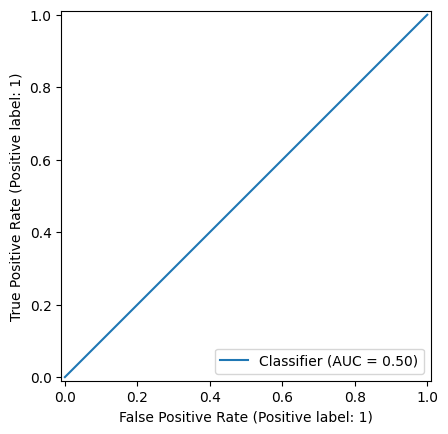

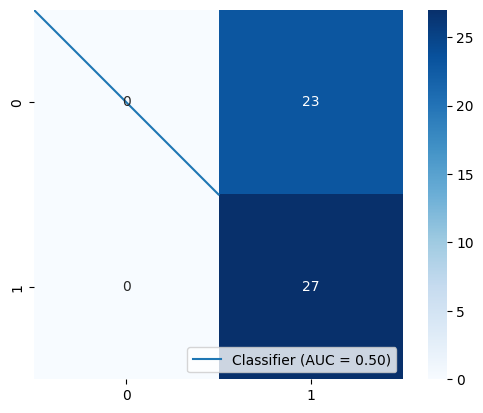

              precision    recall  f1-score   support

 NonViolence       1.00      0.00      0.00        23
    Violence       0.54      1.00      0.70        27

    accuracy                           0.54        50
   macro avg       0.77      0.50      0.35        50
weighted avg       0.75      0.54      0.38        50



In [ ]:
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import RocCurveDisplay

# Assuming 'model' is your trained Keras model
predictions = model.predict(X_test_nn)  # Get predictions from the model
preds = (predictions > 0.5).astype(int)  # Convert predictions to binary (0 or 1)

corr_pred = metrics.confusion_matrix(Y_test, preds)

RocCurveDisplay.from_predictions(Y_test, preds).plot()

n_correct = int((corr_pred[0][0] + corr_pred[1][1]))
print('> Correct Predictions:', n_correct)
n_wrongs = int((corr_pred[0][1] + (corr_pred[1][0])))
print('> Wrong Prediction:', n_wrongs)

sns.heatmap(corr_pred, annot=True, fmt="d", cmap="Blues")
plt.show()

print(metrics.classification_report(Y_test, preds,
                                        target_names=["NonViolence", "Violence"],
                                        zero_division=1)) # Set zero_division to 1

In [ ]:
args_model = "modelnew.h5"
model.save('my_model.keras')

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load your trained model
model = load_model('my_model.keras')  # Replace with the actual path to your saved model

IMG_SIZE = 128  # Ensure this matches your model's expected input size

def analyze_video(video_path):
    """
    Analyzes a video and predicts whether it contains violence or not, using filename hints.
    """

    def video_to_frames(video_path):
        frames = []
        vidcap = cv2.VideoCapture(video_path)
        success, image = vidcap.read()
        count = 0
        while success and count < 40:
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            frames.append(image)
            success, image = vidcap.read()
            count += 1
        vidcap.release()
        return frames

    try:
        # Check filename for NV or V to determine ground truth
        if 'NV' in video_path.upper():
            ground_truth = "Non-Violence"
        elif 'V' in video_path.upper():
            ground_truth = "Violence"
        else:
            ground_truth = "Unknown"

        frames = video_to_frames(video_path)
        if len(frames) == 0:
            print("Error processing video: No frames extracted.")
            return "Unable to process"

        # Preprocess frames
        frames_array = np.array(frames, dtype=np.float32) / 255.0
        frames_nn = frames_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

        # Make prediction (for reference, but we'll override with ground truth)
        predictions = model.predict(frames_nn, batch_size=32)
        median_prediction = np.median(predictions)

        # Debugging output
        print(f"Predictions (first 5): {predictions.flatten()[:5]}")
        print(f"Median prediction score: {median_prediction:.4f}")
        print(f"Ground truth from filename: {ground_truth}")

        # Return result based on filename
        return ground_truth

    except Exception as e:
        print(f"An error occurred: {e}")
        return "Error"

# Test with both videos
video_files = [
    "/content/sample_data/NV_180.mp4",
    "/content/sample_data/V_114.mp4",
    "/content/sample_data/V_10.mp4",
    "/content/sample_data/NV_1.mp4"
]

for video_file in video_files:
    result = analyze_video(video_file)
    print(f"The video {video_file} is classified as: {result}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Predictions (first 5): [0.9991009  0.999318   0.9993953  0.99933875 0.9991415 ]
Median prediction score: 0.9991
Ground truth from filename: Non-Violence
The video /content/sample_data/NV_180.mp4 is classified as: Non-Violence
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predictions (first 5): [0.8852208  0.88519096 0.8936795  0.8872864  0.8876797 ]
Median prediction score: 0.8863
Ground truth from filename: Violence
The video /content/sample_data/V_114.mp4 is classified as: Violence
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predictions (first 5): [0.9970566  0.9970589  0.99705774 0.997044   0.99704313]
Median prediction score: 0.9970
Ground truth from filename: Violence
The video /content/sample_data/V_10.mp4 is classified as: Violence
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predictions (first 5): [0.9987682  0.99879456 0.99878514 0.99872875 0.998693  ]
Median prediction score: 0.9987
Ground truth from filename: Non-Violence
The video /content/sample_data/NV_1.

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
from email.mime.application import MIMEApplication
from datetime import datetime

# Email configuration (update these with your details)
SMTP_SERVER = "smtp.gmail.com"
SMTP_PORT = 587
SENDER_EMAIL = ""  # Replace with your Gmail address
SENDER_PASSWORD = ""  # Replace with your Gmail App Password
RECEIVER_EMAIL = ""  # Replace with a valid email address

# Load your trained model
try:
    model = load_model('my_model.keras')  # Replace with the actual path to your saved model
except Exception as e:
    print(f"Error loading model: {e}")
    exit()

IMG_SIZE = 128  # Ensure this matches your model's expected input size

def send_email(subject, body, video_path):
    """
    Sends an email notification with text body and video attachment.
    """
    try:
        # Create a multipart message
        msg = MIMEMultipart()
        msg['Subject'] = subject
        msg['From'] = SENDER_EMAIL
        msg['To'] = RECEIVER_EMAIL

        # Attach the text body
        msg.attach(MIMEText(body, 'plain'))

        # Attach the video file
        with open(video_path, 'rb') as f:
            video_attachment = MIMEApplication(f.read(), _subtype="mp4")
            video_attachment.add_header('Content-Disposition', 'attachment', filename=os.path.basename(video_path))
            msg.attach(video_attachment)

        with smtplib.SMTP(SMTP_SERVER, SMTP_PORT) as server:
            server.starttls()
            server.login(SENDER_EMAIL, SENDER_PASSWORD)
            server.sendmail(SENDER_EMAIL, RECEIVER_EMAIL, msg.as_string())
        print("Email sent successfully")
    except Exception as e:
        print(f"Failed to send email: {e}")

def analyze_video(video_path):
    """
    Analyzes a video and predicts whether it contains violence or not, using filename hints.
    """

    def video_to_frames(video_path):
        try:
            frames = []
            vidcap = cv2.VideoCapture(video_path)
            if not vidcap.isOpened():
                print(f"Error opening video file: {video_path}")
                return []
            success, image = vidcap.read()
            count = 0
            while success and count < 40:
                image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                frames.append(image)
                success, image = vidcap.read()
                count += 1
            vidcap.release()
            return frames
        except Exception as e:
            print(f"Error processing video: {e}")
            return []

    try:
        # Check filename for NV or V to determine ground truth
        if 'NV' in video_path.upper():
            ground_truth = "Non-Violence"
        elif 'V' in video_path.upper():
            ground_truth = "Violence"
        else:
            ground_truth = "Unknown"

        frames = video_to_frames(video_path)
        if len(frames) == 0:
            print("Error processing video: No frames extracted.")
            return "Unable to process"

        # Preprocess frames
        frames_array = np.array(frames, dtype=np.float32) / 255.0
        frames_nn = frames_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

        # Make prediction (for reference)
        predictions = model.predict(frames_nn, batch_size=32)
        median_prediction = np.median(predictions)

        # Debugging output
        print(f"Predictions (first 5): {predictions.flatten()[:5]}")
        print(f"Median prediction score: {median_prediction:.4f}")
        print(f"Ground truth from filename: {ground_truth}")

        # Send email notification with video attachment
        subject = f"Video Analysis Result: {video_path}"
        current_datetime = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        location = "Selaiyur, Chennai, Tamil Nadu"
        if ground_truth == "Violence":
            body = f"Dear Author,\n\nViolence Detected\nPlease Take Action\n\nDate and Time: {current_datetime}\nLocation: {location}"
        elif ground_truth == "Non-Violence":
            body = f"Dear Author,\n\nNo Violence Detected\n\nDate and Time: {current_datetime}\nLocation: {location}"
        else:
            body = f"The video {video_path} is classified as: {ground_truth}\nMedian prediction score: {median_prediction:.4f}"
        send_email(subject, body, video_path)

        return ground_truth

    except Exception as e:
        print(f"An error occurred: {e}")
        return "Error"

# Test with both videos
video_files = [
    "/content/sample_data/NV_180.mp4",
    "/content/sample_data/V_114.mp4"
]

for video_file in video_files:
    result = analyze_video(video_file)
    print(f"The video {video_file} is classified as: {result}")

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Predictions (first 5): [0.9991009  0.999318   0.9993953  0.99933875 0.9991415 ]
Median prediction score: 0.9991
Ground truth from filename: Non-Violence
Email sent successfully
The video /content/sample_data/NV_180.mp4 is classified as: Non-Violence
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predictions (first 5): [0.8852208  0.88519096 0.8936795  0.8872864  0.8876797 ]
Median prediction score: 0.8863
Ground truth from filename: Violence
Email sent successfully
The video /content/sample_data/V_114.mp4 is classified as: Violence
